In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import os
import pandas as pd

In [2]:
DATA_FOLDER = "/autofs/thau03a/datasets/c1_muse_perception"
FACES_FOLDER = os.path.join(DATA_FOLDER, "raw","faces")

In [3]:
LABELS_PATH = os.path.join(DATA_FOLDER, "labels.csv")

In [4]:
labels = pd.read_csv(LABELS_PATH)

In [5]:
subj_id = 3
faces_paths = os.listdir(os.path.join(FACES_FOLDER, str(subj_id)))
# Sort the faces by their number
faces_paths.sort(key=lambda x: int(x.split("_")[1].split(".")[0]))
# Skip 16th of the faces
faces_paths = faces_paths[::16]
print(faces_paths)

['3_0_0.jpg', '3_8000_0.jpg', '3_16000_0.jpg', '3_24000_0.jpg']


In [6]:
model_path = "/autofs/thau00a/home/sestebanro/thau01/models/Qwen-VL-Chat-Int4"
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)

# Delete the model if it is already loaded
if "model" not in locals():
    # use cuda device
    model = AutoModelForCausalLM.from_pretrained(model_path, device_map="cuda", trust_remote_code=True).eval()

CUDA extension not installed.
CUDA extension not installed.
/autofs/thau00a/home/imartinf/data_thau03/MuSe-2024-THAU/.venv/lib/python3.10/site-packages/transformers/modeling_utils.py:4481: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Some weights of the model checkpoint at /autofs/thau00a/home/sestebanro/thau01/models/Qwen-VL-Chat-Int4 were not used when initializing QWenLMHeadModel: ['transformer.h.0.attn.c_proj.bias', 'transformer.h.0.mlp.c_proj.bias', 'transformer.h.0.mlp.w1.bias', 'transformer.h.0.mlp.w2.bias', 'transformer.h.1.attn.c_proj.bias', 'transformer.h.1.mlp.c_proj.bias', 'transformer.h.1.mlp.w1.bias', 'transformer.h.1.mlp.w2.bias', 'transformer.h.10.attn.c_proj.bias', 'transformer.h.10.mlp.c_proj.bias', 'transformer.h.10.mlp.w1.bias', 'transformer.h.10.mlp.w2.bias', 'transformer.h.11.attn.c_proj.bias', 'transformer.h.11.mlp.c_proj.bias', 'transformer.h.11.mlp.w1.bias', 'transformer.h.11.mlp.w2.bias', 'transformer.h.12.attn.c_proj.bias', 'transformer.h.12.mlp.c_proj.bias', 'transformer.h.12.mlp.w1.bias', 'transformer.h.12.mlp.w2.bias', 'transformer.h.13.attn.c_proj.bias', 'transformer.h.13.mlp.c_proj.bias', 'transformer.h.13.mlp.w1.bias', 'transformer.h.13.mlp.w2.bias', 'transformer.h.14.attn.c_proj.bi

In [7]:
text_prompt_beg = "The following images show the face of a CEO that is giving a speech.\n"
subj_labels = labels[labels["subj_id"] == subj_id].drop(columns=["subj_id"])
text_prompt_end = "The goal of the task is to characterize the social perception of the CEO based on the images, according to 16 variables related to the Dual Perspective Model: aggressiveness, arrogance, assertiveness, confidence, dominance, independence, leadership qualities, and risk-taking propensity (pertaining to agency), and like collaboration, enthusiasm, friendliness, good-naturedness, kindness, likability, sincerity, and warmth (associated with communality)."
prompt_list = [
    {"text": text_prompt_beg},
]

for i, face_path in enumerate(faces_paths):
    face_path = os.path.join(FACES_FOLDER, str(subj_id), face_path)
    prompt_list.append({"image": face_path})

prompt_list.append({"text": text_prompt_end})

query = tokenizer.from_list_format(prompt_list)

inputs = tokenizer(query, return_tensors='pt')
inputs = inputs.to(model.device)

In [8]:
query

'The following images show the face of a CEO that is giving a speech.\nPicture 1: <img>/autofs/thau03a/datasets/c1_muse_perception/raw/faces/3/3_0_0.jpg</img>\nPicture 2: <img>/autofs/thau03a/datasets/c1_muse_perception/raw/faces/3/3_8000_0.jpg</img>\nPicture 3: <img>/autofs/thau03a/datasets/c1_muse_perception/raw/faces/3/3_16000_0.jpg</img>\nPicture 4: <img>/autofs/thau03a/datasets/c1_muse_perception/raw/faces/3/3_24000_0.jpg</img>\nThe goal of the task is to characterize the social perception of the CEO based on the images, according to 16 variables related to the Dual Perspective Model: aggressiveness, arrogance, assertiveness, confidence, dominance, independence, leadership qualities, and risk-taking propensity (pertaining to agency), and like collaboration, enthusiasm, friendliness, good-naturedness, kindness, likability, sincerity, and warmth (associated with communality).'

In [56]:
query_tokens = tokenizer.convert_ids_to_tokens(tokenizer.encode(query))
# Search for the position of the images in the query tokens
# A sequence of image tokens is enclosed by the "<img>" and "</img>" tokens
img_tokens = ["<img>", "</img>"]
img_positions = []
for i, token in enumerate(query_tokens):
    if token == img_tokens[0]:
        img_positions.append(i)
    elif token == img_tokens[1]:
        img_positions.append(i)

img_positions

img_positions[7] - img_positions[6]


257

In [9]:
result = model.generate(**inputs, output_hidden_states=False, return_dict_in_generate=True, max_new_tokens=1, output_attentions=True)

In [10]:
result.keys()

odict_keys(['sequences', 'attentions', 'past_key_values'])

In [11]:
len(result.attentions[0])

32

In [12]:
result.attentions[0][0].shape

torch.Size([1, 32, 1160, 1160])

In [41]:
tokenizer.decode(result.sequences[0])

'The following images show the face of a CEO that is giving a speech.\nPicture 1: <img>/autofs/thau03a/datasets/c1_muse_perception/raw/faces/3/3_0_0.jpg</img>\nPicture 2: <img>/autofs/thau03a/datasets/c1_muse_perception/raw/faces/3/3_8000_0.jpg</img>\nPicture 3: <img>/autofs/thau03a/datasets/c1_muse_perception/raw/faces/3/3_16000_0.jpg</img>\nPicture 4: <img>/autofs/thau03a/datasets/c1_muse_perception/raw/faces/3/3_24000_0.jpg</img>\nThe goal of the task is to characterize the social perception of the CEO based on the images, according to 16 variables related to the Dual Perspective Model: aggressiveness, arrogance, assertiveness, confidence, dominance, independence, leadership qualities, and risk-taking propensity (pertaining to agency), and like collaboration, enthusiasm, friendliness, good-naturedness, kindness, likability, sincerity, and warmth (associated with communality). The'

(1160, 1160)


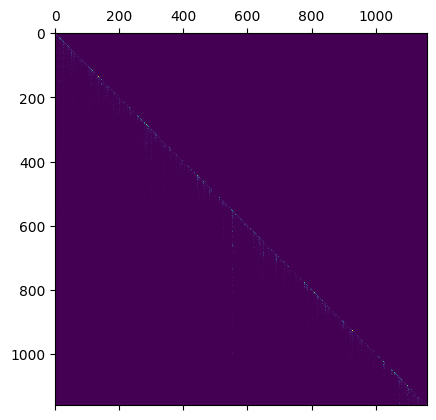

In [79]:
# Plot the attention scores
import matplotlib.pyplot as plt
import numpy as np

att_next_token = result.attentions[0]
layer = -1
head = 0
attentions_to_display = att_next_token[layer][0][head].cpu().detach().numpy()
print(attentions_to_display.shape)
plt.matshow(attentions_to_display)
plt.show()

(257, 1160)


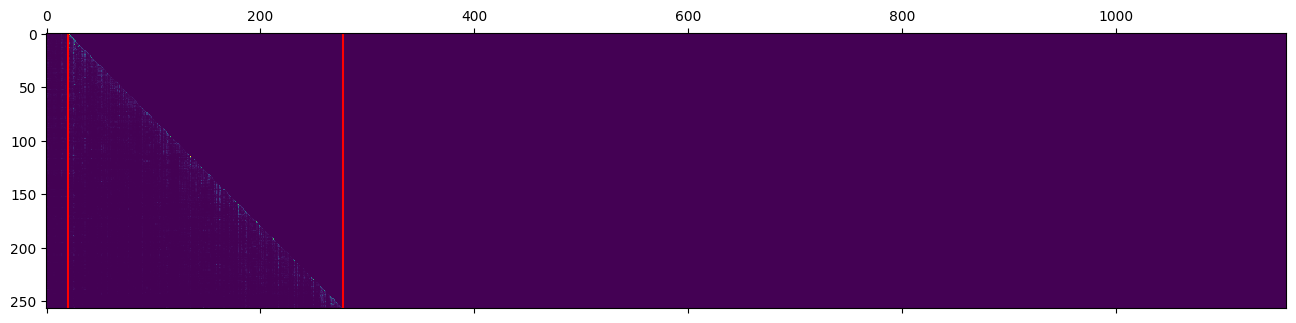

In [80]:
# Show the attention from each token to only the image tokens
which_image = 0
attentions_to_display = att_next_token[layer][0][head][img_positions[2*which_image]:img_positions[2*which_image+1], :].cpu().detach().numpy()
print(attentions_to_display.shape)
# Show the original token positions in both axes (log scale)
plt.matshow(attentions_to_display, aspect='auto')
# Add a red frame around the image tokens positions
plt.axvline(x=img_positions[2*which_image], color='r')
plt.axvline(x=img_positions[2*which_image+1], color='r')
plt.show()

(1160,)


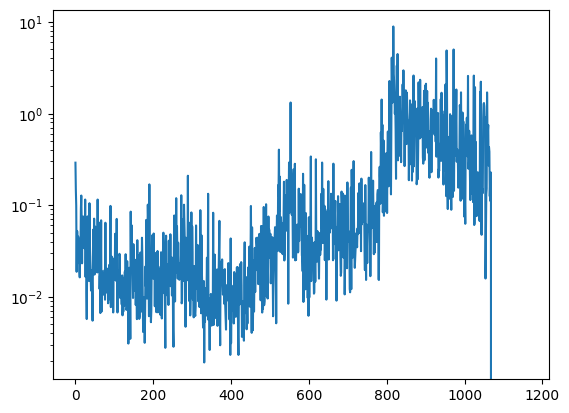

In [94]:
# Lineplot of the sum of the attention scores from each token to all the image tokens for a given image
which_image = 3
attentions_to_display = att_next_token[layer][0][head][img_positions[2*which_image]:img_positions[2*which_image+1], :].sum(axis=0).cpu().detach().numpy()
print(attentions_to_display.shape)
plt.plot(attentions_to_display)
# Log y axis
plt.yscale("log")
plt.show()

In [ ]:
hidden = result["hidden_states"][0] # Only generate one token so result["hidden_states"] has length 1
print(len(hidden)) # A feature map per layer (33)
print(hidden[0].shape) # The feature map has shape (seq_length, hidden_state_dim)

33
torch.Size([1, 1302, 4096])


In [ ]:
import torch
all_hidden = torch.stack(result["hidden_states"][0], dim=0).squeeze(1)
print(all_hidden.shape) # (num_layers, seq_length, hidden_state_dim)
all_hidden_last_token = all_hidden[:, -1, :]
print(all_hidden_last_token.shape) # (num_layers, hidden_state_dim)

torch.Size([33, 1302, 4096])
torch.Size([33, 4096])


In [ ]:
# Compare the difference in storage space between saving all the hidden states and just the last token by saving the hidden states in a file
torch.save(all_hidden, "all_hidden.pt")
torch.save(all_hidden_last_token, "all_hidden_last_token.pt")

import os
print(f"all_hidden.pt size: {os.path.getsize('all_hidden.pt') / 1024 / 1024} MB")
print(f"all_hidden_last_token.pt size: {os.path.getsize('all_hidden_last_token.pt') / 1024 / 1024} MB")
print(all_hidden.shape[0] * all_hidden.shape[1] * all_hidden.shape[2] * 4 / 1024 / 1024) # 4 bytes per float32
print(all_hidden_last_token.shape[0] * all_hidden_last_token.shape[1] * 4 / 1024 / 1024) # 4 bytes per float32

all_hidden.pt size: 335.6730146408081 MB
all_hidden_last_token.pt size: 335.6730670928955 MB
671.34375
0.515625
